In [1]:
import os, time
import numpy as np
import matplotlib.pyplot as plt

from pynq import Overlay

import mkidgen3
from mkidgen3.drivers.ppssync import *
from mkidgen3.server.feedline_config import *
from mkidgen3.server.waveform import WaveformFactory
from mkidgen3.equipment_drivers.ifboard import IFBoard
import mkidgen3.plotting
from mkidgen3.plotting import plot_waveforms, plot_comp_sat, plot_ddc, plot_single_res_sweep
from mkidreadoutanalysis.mkidnoiseanalysis import plot_psd

from mkidgen3.util import rx_power, convert_freq_to_ddc_bins, pseudo_random_tones
from mkidgen3.power_sweep_helpers import get_iq_point, single_res_sweep, compute_lo_steps, get_iq_point
from mkidgen3.opfb import opfb_bin_number
from mkidgen3.mkid_setup.loop_locator import *
from mkidgen3.mkid_setup.sweeps import * 
from mkidgen3.g3_paper import *
import scipy.optimize as spo
import scipy.signal as sig
from mkidgen3.system_parameters import DAC_SAMPLE_RATE, DAC_FREQ_RES, DAC_LUT_SIZE
import tqdm.notebook as tqdm


 <a class="anchor" id="table"></a>
# Table of Contents
* [0.System Setup](#setup)
    * [0.0.3 Tune Power](#power)
* [1. FPGA Direct Loopback](#fpga)
    * [1.1 Phase Noise in 1 Channel](#phase1)
* [2. IF Board Loopback](#if)
    * [2.1.1 Phase Noise in 1 Channel, 1 Tone](#phase2)
    * [2.2.1 Phase Noise in 1 Channel, 2048 Tones](#phase3)
* [3. Fridge Testing Parmp, Elson](#fridge)
    * [3.1.1 Single Resonator Setup, full DAC Dynamic Range](#fridge1)
    * [3.1.2 Single Resonator Setup, 1/200 DAC Dynamic Range](#fridge2)
    * [3.1.3 Single Resonator Setup, 1/200 DAC Dynamic Range, 2048 other uniform tones](#fridge3)
    * [3.1.4 Single Resonator Setup, 1/100 DAC Dynamic Range, 1024 other uniform tones](#fridge4)


# 0.0 Start Clocking, Download Bitstream  <a class="anchor" id="setup"></a>

In [2]:
# Set Board Timezone
os.environ['TZ'] = 'right/UTC'
time.tzset()

In [3]:
# Download Overlay, Optionally Configure Clocks
bitstream='/home/xilinx/gen3_top_final.bit'
mkidgen3.drivers.rfdcclock.configure(programming_key='4.096GSPS_MTS_dualloop',clock_source='external')
time.sleep(0.5)
ol = Overlay(bitstream, ignore_version=True, download=True)
mkidgen3.quirks.Overlay(ol).post_configure()

In [4]:
ol.rfdc.enable_mts()
ol.rfdc.enable_mts()

## 0.0.1 Start PPS SYNC

In [5]:
ol.pps_synchronization.pps_synchronizer_con_0.start_engine(PPSMode.FORCE_START, skew = 1000*1000*1000,
                                                                  clk_period_ns=1/256e-3)

## Program Matched Filters

In [6]:
filtercfg=FilterConfig(coefficients=f'unity{2048}')
ol.photon_pipe.phasematch.configure(**filtercfg.settings_dict())

# Single Tone Noise Floor

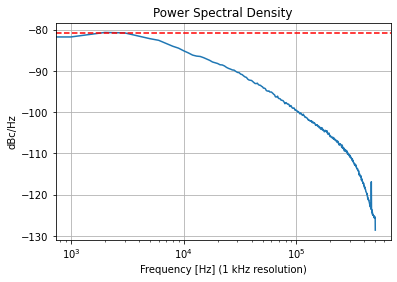

In [27]:
f, psd, floor = get_single_tone_phase_psd(np.array([tones[3]]), 0.95, ol, 5e3, program_matched_filt=False, plot=True)


In [60]:
tones = pseudo_random_tones(2048, buffer=300e3, spread=True)

In [61]:
#tones = tones[0::100]
psd_floors = np.zeros(tones.shape)

In [62]:
tones

array([-2.04766905e+09, -2.04645858e+09, -2.04443352e+09, ...,
        2.04235717e+09,  2.04436258e+09,  2.04628764e+09])

In [ ]:
for i, tone in tqdm.tqdm(enumerate(tones), total=len(tones), desc="TONES"):
    f, psd, floor = get_single_tone_phase_psd(np.array([tone]), 0.95, ol, 5e3, program_matched_filt=False, plot=False)
    psd_floors[i] = floor

TONES:   0%|          | 0/2048 [00:00<?, ?it/s]

In [ ]:
folder = '/nfs/wheatley/j_g3_data/'

file_name = f'rfdc_loopback_psd_floor_vs_freq_1tone{i:002d}.npz'
np.savez(os.path.join(folder, file_name),tones=tones,psd_floors=psd_floors)

In [65]:
data = np.load('/nfs/wheatley/j_g3_data/rfdc_loopback_psd_floor_vs_freq_1tone.npz')

In [66]:
psd_floors_load = data['psd_floors']

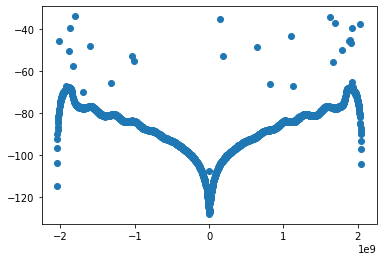

In [70]:
plt.plot(tones, 10*np.log10(psd_floors), "o")

# Multi Tone Noise Floor

In [120]:
ro_tones = pseudo_random_tones(2048, buffer=300e3, spread=True)

n_tones = 1000
static_tones = pseudo_random_tones(n_tones, buffer=300e3, spread=True)

In [121]:
#ro_tones = ro_tones[1135:1146]
psd_floors = np.zeros(ro_tones.shape)
ro_tones_actual = np.zeros(ro_tones.shape)

In [ ]:
for i, ro_tone in tqdm.tqdm(enumerate(ro_tones), total=len(ro_tones), desc="TONES"):
    f, psd, floor, ro_tone = get_multi_tone_phase_psd(np.array([ro_tone]), static_tones, 0.95, ol, 5e3, program_matched_filt=False, plot=False)
    psd_floors[i] = floor
    ro_tones_actual[i] = ro_tone

TONES:   0%|          | 0/2048 [00:00<?, ?it/s]

In [ ]:
folder = '/nfs/wheatley/j_g3_data/'

file_name = f'rfdc_loopback_psd_floor_vs_freq_1000tones_3.npz'
np.savez(os.path.join(folder, file_name),tones=ro_tones_actual,psd_floors=psd_floors)

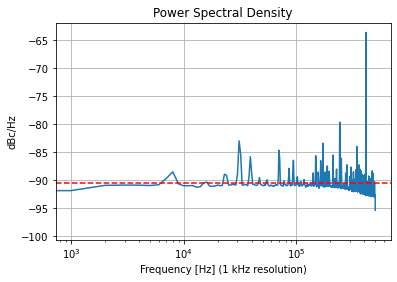

In [82]:
f, psd, floor, _ = get_multi_tone_phase_psd(np.array([ro_tones[1036]]), static_tones, 0.95, ol, 5e3, program_matched_filt=False, plot=True)

In [78]:
ro_tones[1034]

20682387.300425693

/tmp/ipykernel_42711/1489886054.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(ro_tones_actual, 10*np.log10(psd_floors), "o")


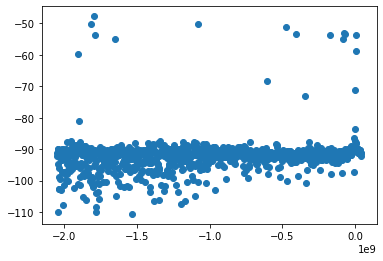

In [72]:
plt.plot(ro_tones_actual, 10*np.log10(psd_floors), "o")

# Multi-Tone-Noise Floor Optimal for Many Tones

In [89]:
ro_tones = pseudo_random_tones(2048, buffer=300e3, spread=True)

n_tones = 1000
static_tones = pseudo_random_tones(n_tones, buffer=300e3, spread=True)

n_unique_ro = ro_tones.shape[0]-static_tones.shape[0]
hybrid_tones = np.concatenate((ro_tones[:n_unique_ro//2], static_tones, ro_tones[-n_unique_ro//2:]))

In [115]:
ro_tones = pseudo_random_tones(2048, buffer=300e3, spread=True)

n_tones = 1000
static_tones = pseudo_random_tones(n_tones, buffer=300e3, spread=True)

n_unique_ro = ro_tones.shape[0]-static_tones.shape[0]
hybrid_tones = np.concatenate((ro_tones[:n_unique_ro//2], static_tones, ro_tones[-n_unique_ro//2:]))
psd_floors = np.zeros(hybrid_tones.shape)

In [116]:
for i, ro_tone in tqdm.tqdm(enumerate(hybrid_tones), total=len(hybrid_tones), desc="TONES"):
    if i < n_unique_ro//2 or i >= static_tones.shape[0]+n_unique_ro//2:
        # Program DAC Each Time
        wvfm_tones = np.append(ro_tone, static_tones)
        wvfm_cfg = WaveformConfig(waveform=WaveformFactory(frequencies=wvfm_tones, seed=6, dac_dynamic_range=0.95, compute=True))
        ol.dac_table.configure(**wvfm_cfg.settings_dict())
        #print(f'i is {i}, programming dac each iteration')
    else:
        if i == n_unique_ro//2:
            # Program DAC Once
            wvfm_tones = hybrid_tones
            wvfm_cfg = WaveformConfig(waveform=WaveformFactory(frequencies=wvfm_tones, seed=6, dac_dynamic_range=0.95, compute=True))
            ol.dac_table.configure(**wvfm_cfg.settings_dict())
            #print(f'i is {i} programming dac once')
        else:
            #print(f'i is {i} only adjusting bin2res and ddc')
            pass
    
    bins = np.zeros(2048, dtype=int)
    bins[0] = opfb_bin_number(ro_tone, ssr_raw_order=True)

    chan = ChannelConfig(bins=bins)
    ol.photon_pipe.reschan.bin_to_res.configure(**chan.settings_dict())

    ddc_tones = np.zeros(2048)
    ddc_tones[0] = ro_tone

    ddc = DDCConfig(tones=ddc_tones)
    ol.photon_pipe.reschan.ddccontrol_0.configure(**ddc.settings_dict())
    
    x = ol.capture.capture_phase(2 ** 19, [0, 1], tap_location='filtphase')
    phase = np.array(x)
    x.freebuffer()
    phase0 = np.pi * phase[:, 0] / (2 ** 15 - 1)

    f, psd = welch(phase0, fs=1e6, nperseg=1e6 / 1e3)

    floor = fit_psd_floor(f, psd, 5e3)
    psd_floors[i] = floor
    

TONES:   0%|          | 0/2048 [00:00<?, ?it/s]

In [117]:
folder = '/nfs/wheatley/j_g3_data/'

file_name = f'rfdc_loopback_psd_floor_vs_freq_1000tones_2.npz'
np.savez(os.path.join(folder, file_name),tones=ro_tones_actual,psd_floors=psd_floors)

In [118]:
# RUN THIS
folder = '/nfs/wheatley/j_g3_data/'

file_name = f'rfdc_loopback_psd_floor_vs_freq_1000tones_2.npz'
np.savez(os.path.join(folder, file_name),tones=hybrid_tones,psd_floors=psd_floors)

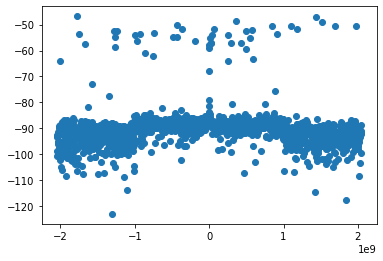

In [119]:
plt.plot(hybrid_tones, 10*np.log10(psd_floors), "o")

Text(0.5, 1.0, 'Power Spectral Density')

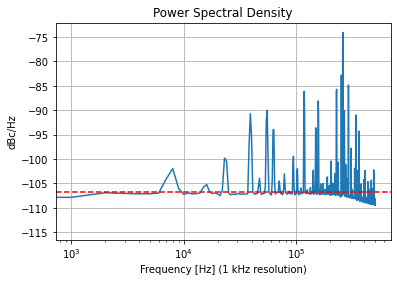

In [111]:
fig, ax = plt.subplots()
ax.semilogx(f, 10 * np.log10(psd))
ax.axhline(10 * np.log10(floor),  color='r', linestyle='--')
ax.set_xlabel(f'Frequency [Hz] ({1e3 * 1e-3:g} kHz resolution)')
ax.set_ylabel('dBc/Hz')
ax.grid()
ax.set_title('Power Spectral Density')

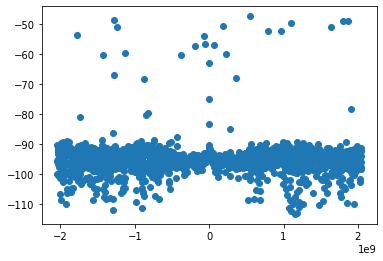

In [63]:
plt.plot(ro_tones_actual, 10*np.log10(psd_floors), "o")

In [81]:
# Capture Phase
x = ol.capture.capture_phase(2**19, [0,1], tap_location='filtphase')
phase = np.array(x)
x.freebuffer()
phase0 = np.pi*phase[:,0]/(2**15-1)

Text(0.5, 1.0, 'Power Spectral Density')

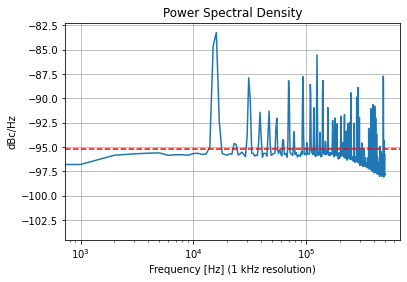

In [26]:
f, psd = welch(phase0, fs=1e6, nperseg=1e6 / 1e3)
floor = fit_psd_floor(f, psd, 5e3)
fig, ax = plt.subplots()
ax.semilogx(f, 10 * np.log10(psd))
ax.axhline(10 * np.log10(floor),  color='r', linestyle='--')
ax.set_xlabel(f'Frequency [Hz] ({1e3 * 1e-3:g} kHz resolution)')
ax.set_ylabel('dBc/Hz')
ax.grid()
ax.set_title('Power Spectral Density')

In [ ]:
plt.plot(psd)

In [74]:
wvfm_cfg.waveform.output_waveform

array([ -5560.-2000.j,  -7436.-2620.j,  12916.+8752.j, ...,
         4008.-6980.j, -16468.+6080.j, -15484.-2616.j])

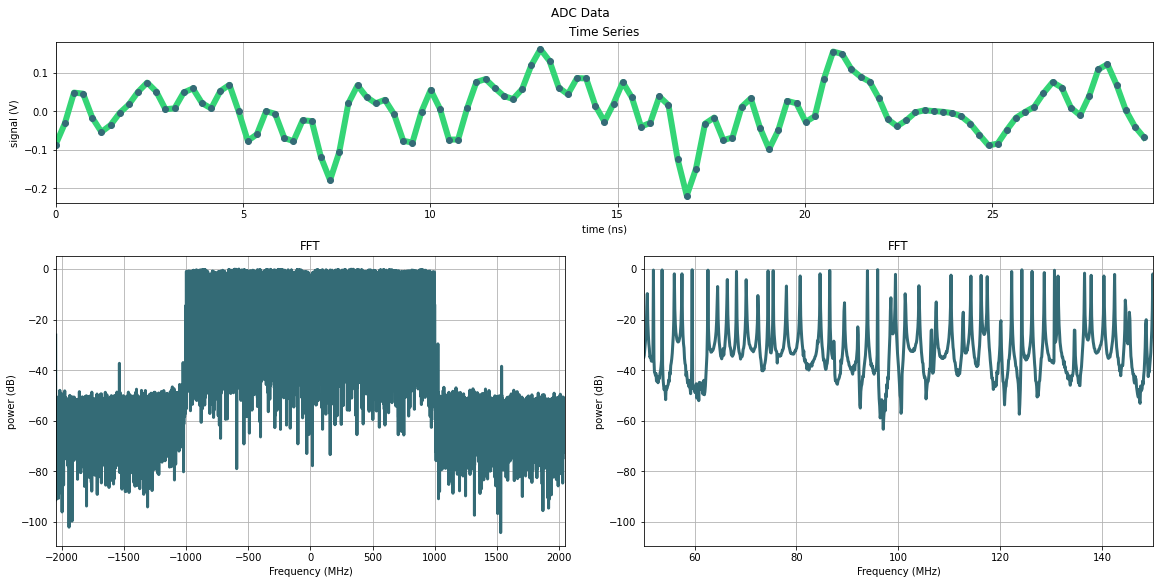

In [18]:
# Capture ADC
x = ol.capture.capture_adc(2**19, complex=False)  # throw away capture to clear any startup garbage
del x
adc_capture_data = ol.capture.capture_adc(2**19, complex=True)
adc_capture_data = adc_capture_data/2**15 # Normalize to 1/2 V
# Plot ADC Data
timerange = (0,120)  # ns
fftrange= (16, 16 + 20*4096) 
fftzoom = (50, 150)
mkidgen3.plotting.adc_test_plot(adc_capture_data, timerange, fftrange, fftzoom)

In [75]:
adc_capture_data = ol.capture.capture_adc(2**23, complex=False)
folder = '/nfs/wheatley/j_g3_data/'

file_name = f'rfdc_loopback_2048_rand_tones_adc.npz'
np.savez(os.path.join(folder, file_name),tones=tones,output_waveform=wvfm_cfg.waveform.output_waveform, adc_snap=adc_capture_data)
del adc_capture_data

# 1.0 FPGA Direct Loopback Measurments  <a class="anchor" id="fpga"></a>
[Table of Contents](#table)

## Hardware Setup: Direct Loopback

<img src="img/direct_loopback.png" style="height:500px">

## 1.1.1 Single Tone, Full DAC Dynamic Range <a class="anchor" id="phase2"></a>

In [21]:
wvfm_tones = np.append(ro_tone, static_tones)
wvfm_cfg = WaveformConfig(waveform=WaveformFactory(frequencies=wvfm_tones, seed=6, dac_dynamic_range=1.0, compute=True))
ol.dac_table.configure(**wvfm_cfg.settings_dict())

[0.0.3 Tune Power](#power)

In [22]:
# Bin2Res + DDC
chan = wvfm_cfg.default_channel_config
ol.photon_pipe.reschan.bin_to_res.configure(**chan.settings_dict())
ddc = wvfm_cfg.default_ddc_config
ol.photon_pipe.reschan.ddccontrol_0.configure(**ddc.settings_dict())

In [48]:
ddc.tones

array([2.22247805e+08, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [52]:
ddc2.tones
ol.photon_pipe.reschan.ddccontrol_0.configure(**ddc2.settings_dict())

In [40]:
# Matched Filter
#filtercfg=FilterConfig(coefficients=f'unity{2048}')
#ol.photon_pipe.phasematch.configure(**filtercfg.settings_dict())

In [55]:
static_tones

array([-10456934.25809046,  -7837058.93075262,  -6094364.54282484,
        -4170307.95231107,  -1904592.28415991,    635035.06934369,
         2352182.45046687,   3774591.95649457,   5523008.39269951,
         8424982.26847397])

In [58]:
ddc.tones

array([2.22247805e+08, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

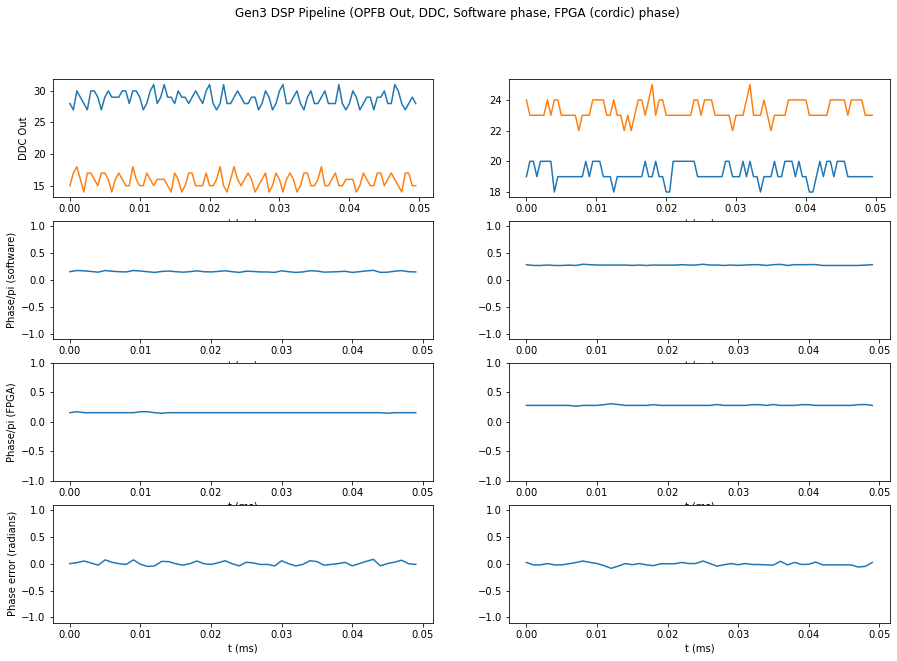

In [23]:
ddciq, phase = ol.capture.cap_cordic_compare()
chan_plt=[0,1]
plot_ddc(ddciq, phase, chan_plt)
None

In [27]:
# Capture Phase
x = ol.capture.capture_phase(2**19, [0,1], tap_location='filtphase')
phase = np.array(x)
x.freebuffer()
phase0 = np.pi*phase[:,0]/(2**15-1)

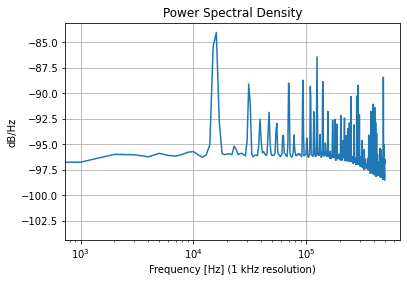

In [29]:
# Plot Phase PSD
plot_psd(phase0, fs=1e6, fres=1e3)

In [13]:
folder = '/nfs/wheatley/j_g3_data/'

for i in range(0,1):
    x = ol.capture.capture_phase(2**25, [0,1], tap_location='filtphase')
    phase = np.pi*x[:,0]/(2**15-1)
    x.freebuffer()
    file_name = f'rfdc_loopback_singletone_phase{i:002d}.npz'
    np.savez(os.path.join(folder, file_name),phase_data=phase)
del phase

## 1.1.1 Single Tone,1/200 DAC Dynamic Range <a class="anchor" id="phase2"></a>

In [37]:
# Run DAC
tones = np.array([100e6])
wvfm_cfg = WaveformConfig(waveform=WaveformFactory(frequencies=tones, seed=6, dac_dynamic_range = 1/200, compute=True))
ol.dac_table.configure(**wvfm_cfg.settings_dict())

[0.0.3 Tune Power](#power)

In [38]:
# Bin2Res + DDC
chan = wvfm_cfg.default_channel_config
ol.photon_pipe.reschan.bin_to_res.configure(**chan.settings_dict())
ddc = wvfm_cfg.default_ddc_config
ol.photon_pipe.reschan.ddccontrol_0.configure(**ddc.settings_dict())

In [39]:
# Matched Filter
#filtercfg=FilterConfig(coefficients=f'unity{2048}')
#ol.photon_pipe.phasematch.configure(**filtercfg.settings_dict())

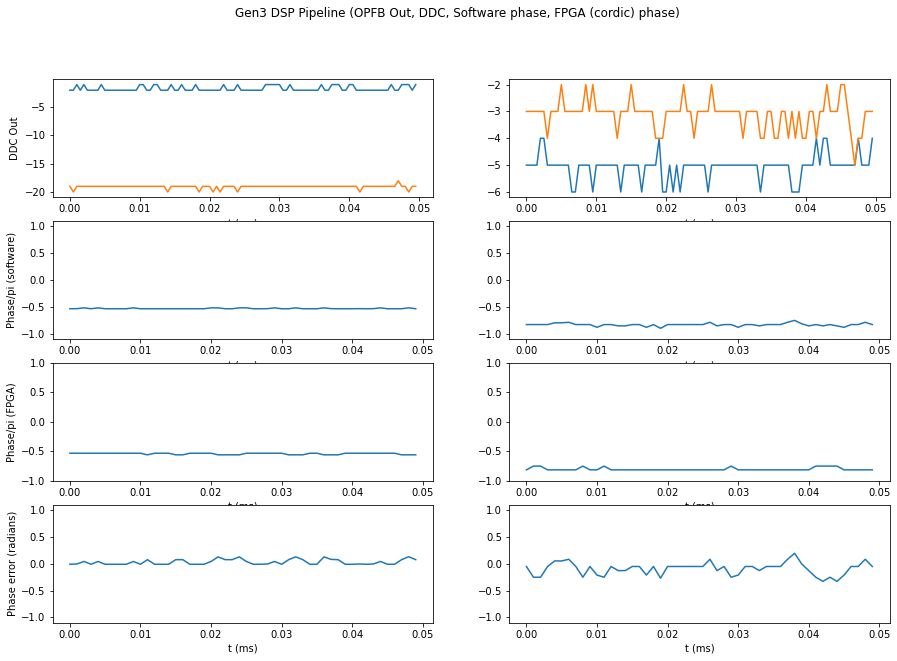

In [40]:
ddciq, phase = ol.capture.cap_cordic_compare()
chan_plt=[0,1]
plot_ddc(ddciq, phase, chan_plt)
None

In [41]:
# Capture Phase
x = ol.capture.capture_phase(2**19, [0,1], tap_location='filtphase')
phase = np.array(x)
x.freebuffer()
phase0 = np.pi*phase[:,0]/(2**15-1)

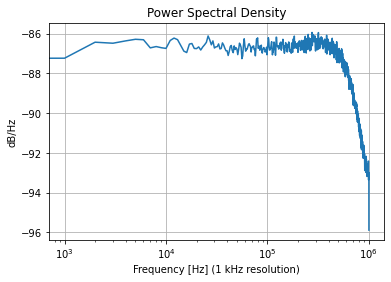

In [42]:
# Plot Phase PSD
plot_psd(phase0, fs=2e6, fres=1e3)

In [20]:
folder = '/nfs/wheatley/j_g3_data/'

for i in range(0,1):
    x = ol.capture.capture_phase(2**25, [0,1], tap_location='filtphase')
    phase = np.pi*x[:,0]/(2**15-1)
    x.freebuffer()
    file_name = f'rfdc_loopback_singletone_smalldr_phase{i:002d}.npz'
    np.savez(os.path.join(folder, file_name),phase_data=phase)
del phase

## 1.1.2 2048 Tones, Realistic Fraction of DAC Dynamic Range <a class="anchor" id="phase3"></a>

In [26]:
from mkidgen3.system_parameters import OPFB_CHANNEL_SAMPLE_RATE, ADC_SAMPLE_RATE, N_OPFB_CHANNELS
buffer=300e3
spread=True
n=2048

opfb_halfband = OPFB_CHANNEL_SAMPLE_RATE / 2
rand_offsets = np.random.uniform(low=buffer-opfb_halfband, high=opfb_halfband/2-buffer,
                                    size=n-1)
bc = (ADC_SAMPLE_RATE / N_OPFB_CHANNELS) * np.linspace(-N_OPFB_CHANNELS / 2, N_OPFB_CHANNELS / 2 - 1,
                                                                    N_OPFB_CHANNELS)
if spread:
    bc = bc[::2]
tone_bin_centers = np.concatenate((bc[bc.size//2-n//2:bc.size//2], bc[bc.size//2+1:+bc.size//2+n//2+1]))
tones = tone_bin_centers + rand_offsets

In [27]:
tones.shape

(2047,)

In [50]:
# Run DAC
#tones = pseudo_random_tones(2048)
wvfm_cfg = WaveformConfig(waveform=WaveformFactory(frequencies=tones, seed=4, dac_dynamic_range = 0.95, compute=True))
tones = wvfm_cfg.waveform.quant_freqs
ol.dac_table.configure(**wvfm_cfg.settings_dict())

In [51]:
# We're going to focus on reading out this one tone around 100 MHz
ro_tone = tones[tones.size//2+100]

[0.0.3 Tune Power](#power)

Since we are running a lot of tones we will only program bin2res and the DDC to readout 1 to conserve some power for these tests. I beleive this is legit because there should be no leakage / crosstalk in the channels after the OPFB.

In [52]:
# Bin2Res + DDC
empty_bin = opfb_bin_number(tones.max() + 100e6, ssr_raw_order=True)
bins = np.zeros(2048, dtype=int)+empty_bin
bins[0] = opfb_bin_number(ro_tone, ssr_raw_order=True)

chan = ChannelConfig(bins=bins)
ol.photon_pipe.reschan.bin_to_res.configure(**chan.settings_dict())

ddc_tones = np.zeros(2048)
ddc_tones[0] = ro_tone

ddc = DDCConfig(tones=ddc_tones)
ol.photon_pipe.reschan.ddccontrol_0.configure(**ddc.settings_dict())

In [53]:
#ol.photon_pipe.reschan.ddccontrol_0.reset_phase_center()

In [54]:
# Matched Filter
#filtercfg=FilterConfig(coefficients=f'unity{2048}')
#ol.photon_pipe.phasematch.configure(**filtercfg.settings_dict())

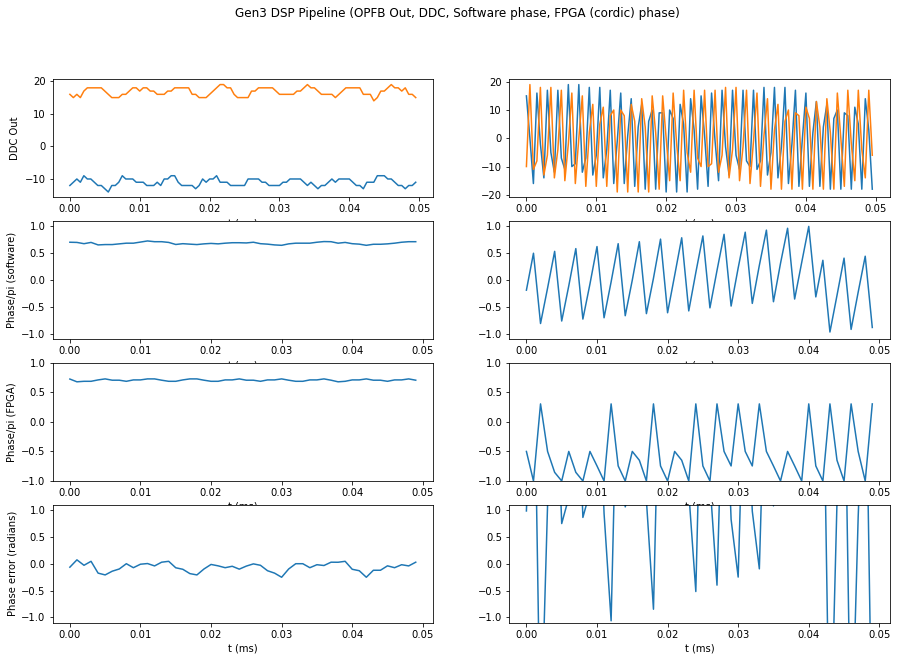

In [55]:
ddciq, phase = ol.capture.cap_cordic_compare()
chan_plt=[0,1]
plot_ddc(ddciq, phase, chan_plt)
None

In [56]:
# Capture Phase
x = ol.capture.capture_phase(2**19, [0,1], tap_location='filtphase')
phase = np.array(x)
x.freebuffer()
phase0 = np.pi*phase[:,0]/(2**15-1)

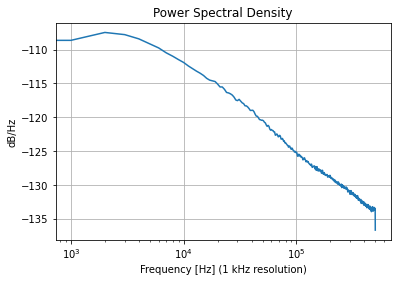

In [13]:
# Plot Phase PSD
plot_psd(phase0, fs=1e6, fres=1e3)

In [53]:
def fit_psd_floor(freqs, spect):
    def flatoverf(freq, a, b):
        return a + b / freq

    fitcutoff = np.argmin(np.abs(freqs - 30.e3))  # remove rolloff
    popt, pcov = spo.curve_fit(flatoverf, freqs[1:fitcutoff], spect[1:fitcutoff], sigma=spect[1:fitcutoff])
    return popt[0]

In [45]:
f, psd = welch(phase0, fs=1e6, nperseg=1e6/1e3)

In [54]:
popt = fit_psd_floor(f, psd)

In [47]:
popt

array([ 4.36052956e-09, -4.13942520e-07])

Text(0.5, 1.0, 'Power Spectral Density')

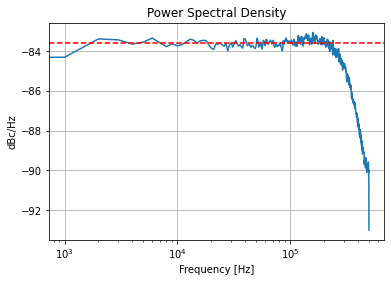

In [60]:
fig, ax = plt.subplots()
ax.semilogx(f, 10 * np.log10(psd))
ax.axhline(10*np.log10(popt), color='r', linestyle='--')
ax.set_xlabel(f'Frequency [Hz]')
ax.set_ylabel('dBc/Hz')
ax.grid()
ax.set_title('Power Spectral Density')

In [27]:
plt.plot(f, popt[:,0])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [58]:
folder = '/nfs/wheatley/j_g3_data/'

for i in range(0,1):
    x = ol.capture.capture_phase(2**25, [0,1], tap_location='filtphase')
    phase = np.pi*x[:,0]/(2**15-1)
    x.freebuffer()
    file_name = f'rfdc_loopback_2000tones_phase{i:002d}.npz'
    np.savez(os.path.join(folder, file_name),phase_data=phase)
del phase